In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/small-lcl-data/LCL-June2015v2_99.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_162.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_68.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_69.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_126.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_23.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_150.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_120.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_26.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_116.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_141.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_98.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_73.csv
/kaggle/input/full-london-smart

In [2]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#!pip install -U pip
#!pip install -U setuptools wheel

#!pip install autogluon


Creat two load forecasts...
1) half-hourly load forecast for next 24 hours
2) peak half-hour in the next 24 hours

Value...
* For electric network operator, minimize the amount of spinning reserve

Data...
* residential smart meter usage data
* weather data
* weather forecast data

# Load Data

In [3]:
# load half-hourly electric usage data
# https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households
d = pd.read_csv('/kaggle/input/small-lcl-data/LCL-June2015v2_99.csv', parse_dates=["DateTime"])

In [4]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   LCLid                    1000000 non-null  object        
 1   stdorToU                 1000000 non-null  object        
 2   DateTime                 1000000 non-null  datetime64[ns]
 3   KWH/hh (per half hour)   1000000 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 30.5+ MB


In [5]:
# convert usage to floats
# print(d.iloc[3])
d.iloc[:, 3] = pd.to_numeric(d.iloc[:, 3], errors='coerce')
# print(d.dtypes)
# rename usage column for easier reference
#d.rename(columns={"KWH/hh (per half hour)": "KWHperHH"}, inplace=True)
d.rename(columns={d.columns[3]: 'KWHperHH'}, inplace=True)
# d.rename_col_by_index(3, 'KWHperHH')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   LCLid     1000000 non-null  object        
 1   stdorToU  1000000 non-null  object        
 2   DateTime  1000000 non-null  datetime64[ns]
 3   KWHperHH  999965 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 30.5+ MB


In [6]:
# set timestamp as the index
d.set_index('DateTime')


LCLid stdorToU  KWHperHH
DateTime                                         
2013-08-06 07:00:00  MAC004221      Std     0.046
2013-08-06 07:30:00  MAC004221      Std     0.040
2013-08-06 08:00:00  MAC004221      Std     0.016
2013-08-06 08:30:00  MAC004221      Std     0.018
2013-08-06 09:00:00  MAC004221      Std     0.016
...                        ...      ...       ...
2013-06-29 07:00:00  MAC004268      Std     0.151
2013-06-29 07:30:00  MAC004268      Std     0.278
2013-06-29 08:00:00  MAC004268      Std     0.128
2013-06-29 08:30:00  MAC004268      Std     0.049
2013-06-29 09:00:00  MAC004268      Std     0.129

[1000000 rows x 3 columns]

In [7]:
from pandas_profiling import ProfileReport

profile = ProfileReport(d, tsmode=True, sortby="DateTime")
profile.to_file('profile_report.html')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# visualize and handle duplicates
# d = d.drop_duplicates()
print(d.groupby(d.columns.tolist(),as_index=False).size())
dupes = d[d.duplicated()]
print('dupes', dupes)
print('dupes.index', dupes.index)
d = d.drop(index=dupes.index)

d.info()

            LCLid stdorToU            DateTime  KWHperHH  size
0       MAC004221      Std 2013-08-06 07:00:00     0.046     1
1       MAC004221      Std 2013-08-06 07:30:00     0.040     1
2       MAC004221      Std 2013-08-06 08:00:00     0.016     1
3       MAC004221      Std 2013-08-06 08:30:00     0.018     1
4       MAC004221      Std 2013-08-06 09:00:00     0.016     1
...           ...      ...                 ...       ...   ...
999282  MAC004268      Std 2013-06-29 07:00:00     0.151     1
999283  MAC004268      Std 2013-06-29 07:30:00     0.278     1
999284  MAC004268      Std 2013-06-29 08:00:00     0.128     1
999285  MAC004268      Std 2013-06-29 08:30:00     0.049     1
999286  MAC004268      Std 2013-06-29 09:00:00     0.129     1

[999287 rows x 5 columns]
dupes             LCLid stdorToU   DateTime  KWHperHH
947     MAC004221      Std 2013-08-26     0.063
2434    MAC004221      Std 2013-09-26     0.041
3923    MAC004221      Std 2013-10-27     0.042
5412    MAC004221  

In [9]:
d.set_index('DateTime')
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999322 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   LCLid     999322 non-null  object        
 1   stdorToU  999322 non-null  object        
 2   DateTime  999322 non-null  datetime64[ns]
 3   KWHperHH  999287 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 38.1+ MB


Visualize smart meter dataset to anayze for quality, completenes and othe insights

In [10]:
import seaborn as sns

<Axes: xlabel='DateTime', ylabel='LCLid'>

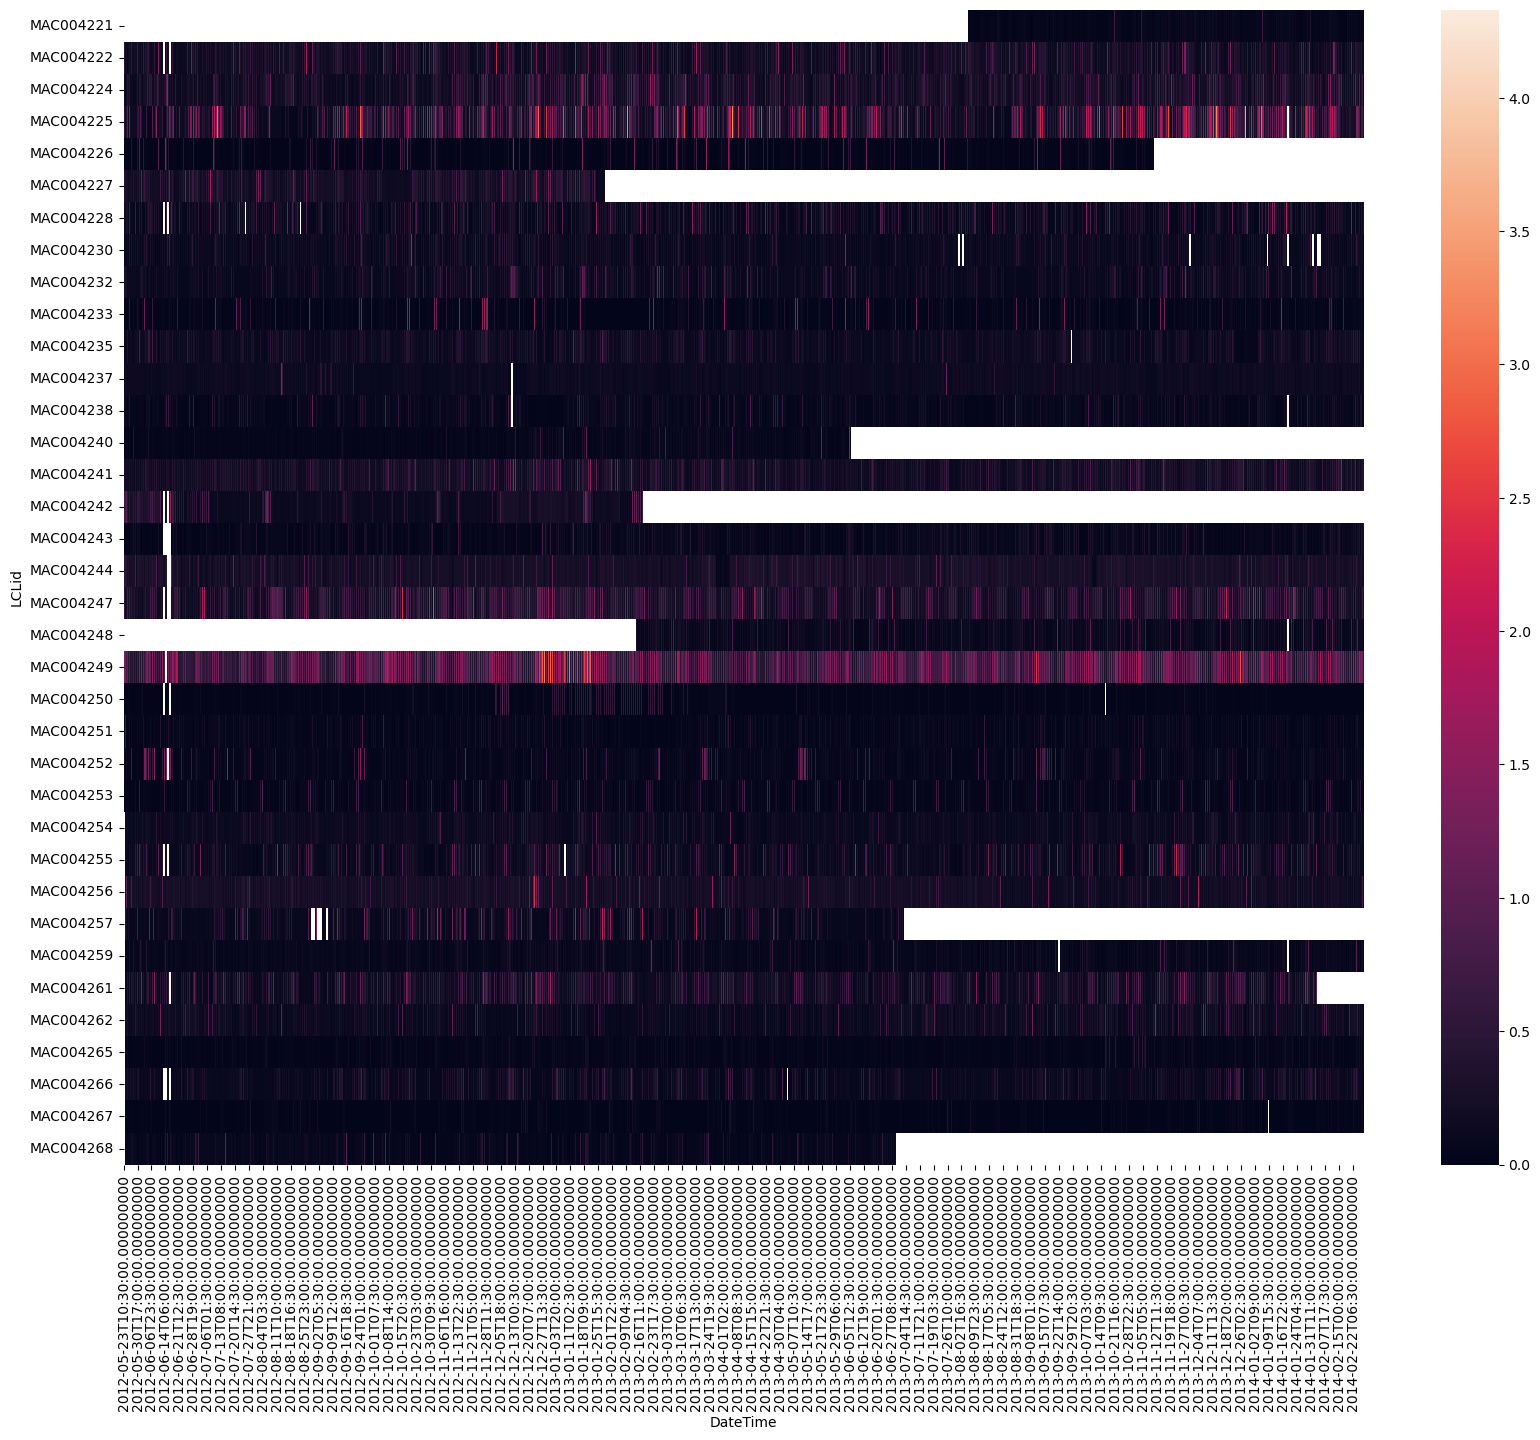

In [11]:
# visualize meter read coverage and completeness
pivot_table = pd.pivot_table(d, columns='DateTime', index='LCLid', values='KWHperHH')
# print(pivot_table)
plt.subplots(figsize=(20,15))
sns.heatmap(pivot_table)


Observations from Heatmap...
* several houses start producing load part-way through the period
    - eg MAC004221, MAC004248
    
    
* several houses stop producing part-way through the period
    - eg MAC004226, MAC004257
    

* most houses have at least one "gap" in their data (visible as white lines)


* several houses stand out as having significantly higher average load than others
    - eg MAC004225, MAC004249

In [12]:
# inspect and remove records not exactly on the half-hour
offRecs = d.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
# aggLoad["DateTime"].dt.hour > 30
print('Records not exactly on the half-hour:\n ', offRecs)
print(offRecs.info())

# delete records not exactly on the half-hour
d = d.drop(offRecs.index)

offRecs = d.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)

Records not exactly on the half-hour:
              LCLid stdorToU            DateTime  KWHperHH
19832   MAC004222      Std 2012-12-18 15:19:59       NaN
50831   MAC004224      Std 2012-12-18 15:19:59       NaN
81839   MAC004225      Std 2012-12-18 15:20:00       NaN
112800  MAC004226      Std 2012-12-18 15:20:00       NaN
138570  MAC004227      Std 2012-12-18 15:20:00       NaN
150455  MAC004228      Std 2012-12-18 15:20:00       NaN
181460  MAC004230      Std 2012-12-18 15:20:00       NaN
212129  MAC004232      Std 2012-12-18 15:20:00       NaN
243135  MAC004233      Std 2012-12-18 15:20:00       NaN
274142  MAC004235      Std 2012-12-18 15:20:01       NaN
305076  MAC004237      Std 2012-12-18 15:20:01       NaN
336032  MAC004238      Std 2012-12-18 15:20:01       NaN
366986  MAC004240      Std 2012-12-18 15:20:01       NaN
385164  MAC004241      Std 2012-12-18 15:20:01       NaN
416071  MAC004242      Std 2012-12-18 15:20:01       NaN
428860  MAC004243      Std 2012-12-18 15:20:02  

In [13]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999287 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   LCLid     999287 non-null  object        
 1   stdorToU  999287 non-null  object        
 2   DateTime  999287 non-null  datetime64[ns]
 3   KWHperHH  999287 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 38.1+ MB


In [14]:
# First step of interpolation is to create NaN records where records are missing
df = d.copy()
df.info()
df = df.sort_values(by=['DateTime'])
df = df.set_index('DateTime')
df.index.rename('DateTime', inplace=True)
df.info()

# df['datetime'] = pd.to_datetime(df['datetime'])
# df.index = df['datetime']
# del df['datetime']

df_interpol = df.groupby('LCLid')\
                .resample('30Min')\
                .mean()
df_interpol['KWHperHH'] = df_interpol['KWHperHH'].interpolate()
df_interpol.info()
df_interpol = df_interpol.reset_index()

# df_interpol['LCLid'], df_interpol['DateTime'] = df_interpol.index
df_interpol.head(4)
df_interpol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999287 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   LCLid     999287 non-null  object        
 1   stdorToU  999287 non-null  object        
 2   DateTime  999287 non-null  datetime64[ns]
 3   KWHperHH  999287 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 38.1+ MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999287 entries, 2012-05-23 10:30:00 to 2014-02-28 00:00:00
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   LCLid     999287 non-null  object 
 1   stdorToU  999287 non-null  object 
 2   KWHperHH  999287 non-null  float64
dtypes: float64(1), object(2)
memory usage: 30.5+ MB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1001751 entries, ('MAC004221', Timestamp('2013-08-06 07:00:00')) to ('MAC004268', Timesta

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001751 entries, 0 to 1001750
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   LCLid     1001751 non-null  object        
 1   DateTime  1001751 non-null  datetime64[ns]
 2   KWHperHH  1001751 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 22.9+ MB


<Axes: xlabel='DateTime', ylabel='LCLid'>

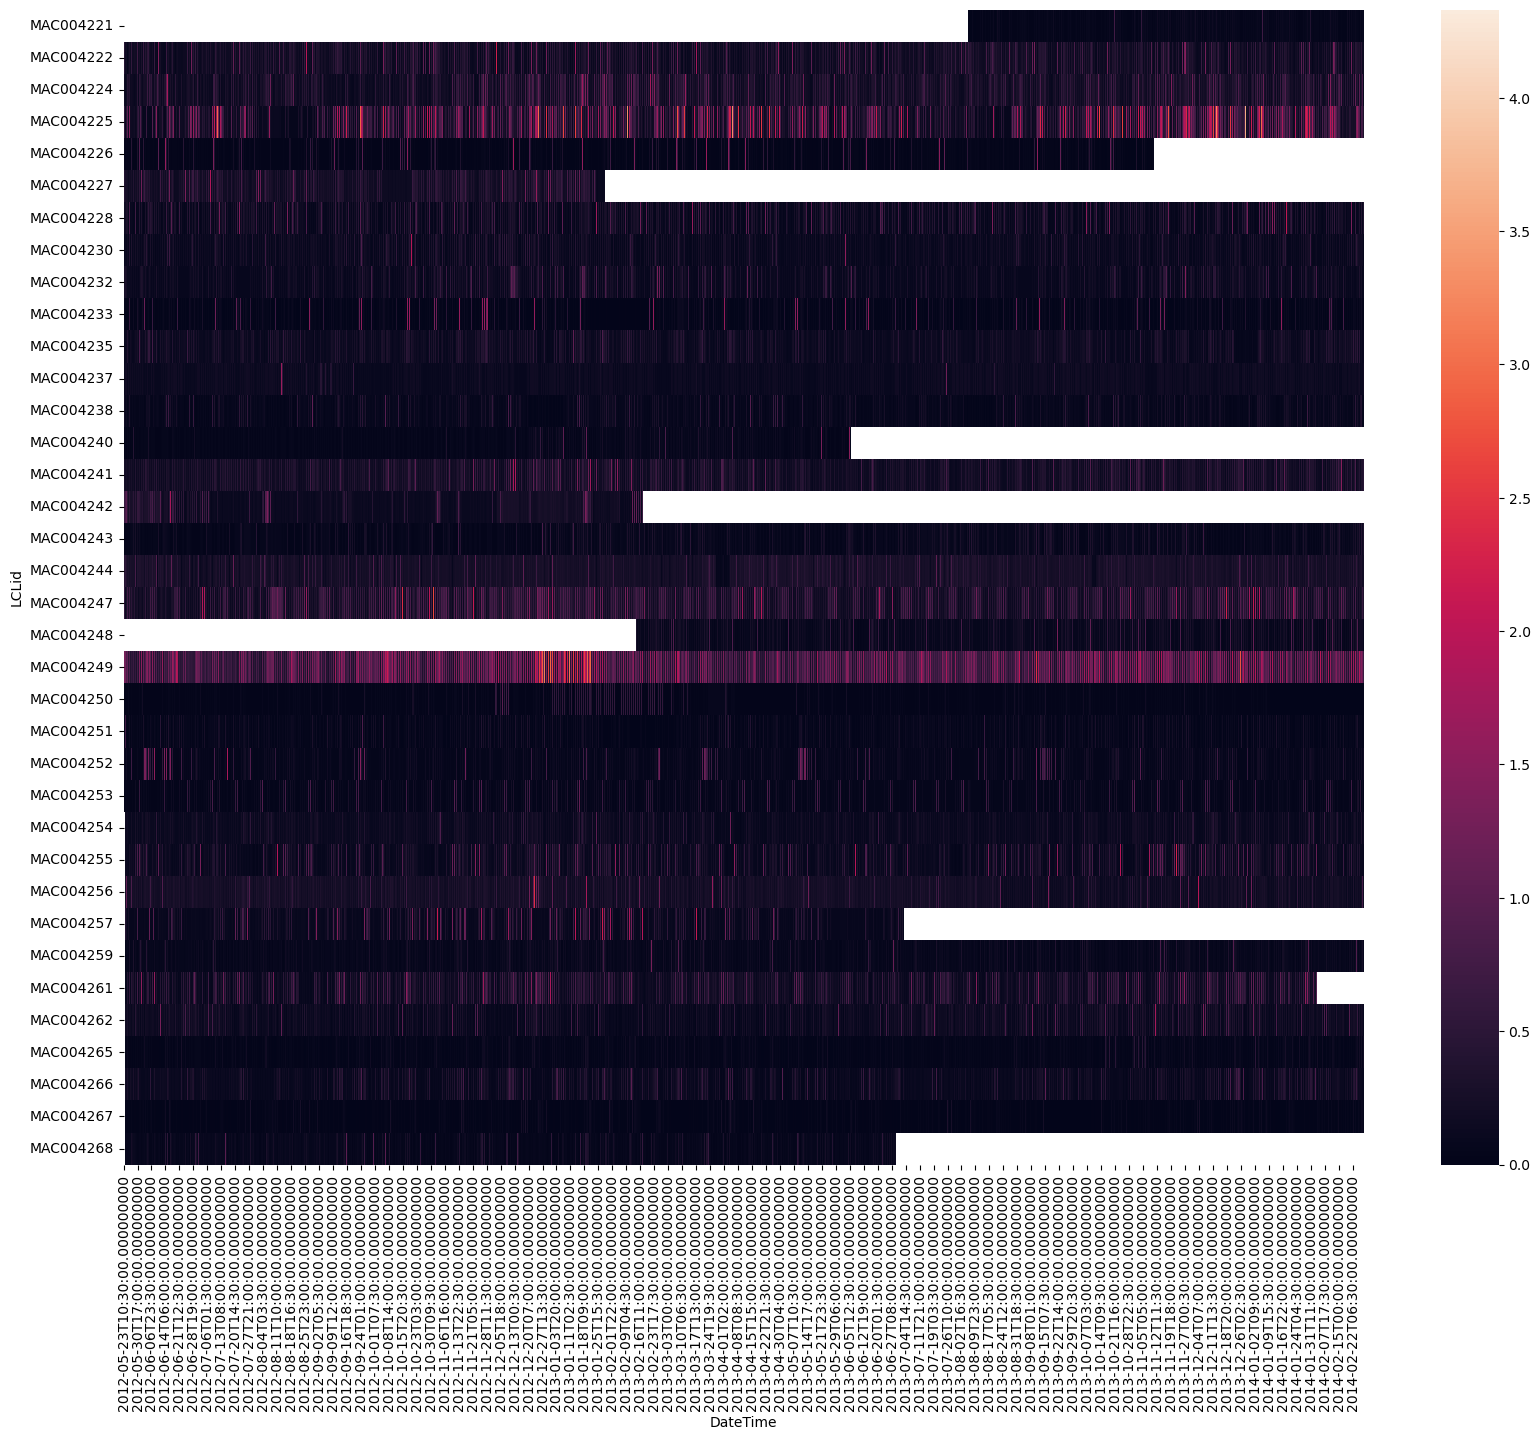

In [15]:
# visualize after interpolating missing values
df_interpol.info()
pivot_table = pd.pivot_table(df_interpol, columns='DateTime', index='LCLid', values='KWHperHH')
plt.subplots(figsize=(20,15))

sns.heatmap(pivot_table)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001751 entries, 0 to 1001750
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   LCLid     1001751 non-null  object        
 1   DateTime  1001751 non-null  datetime64[ns]
 2   KWHperHH  1001751 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 22.9+ MB


<Axes: xlabel='DateTime', ylabel='LCLid'>

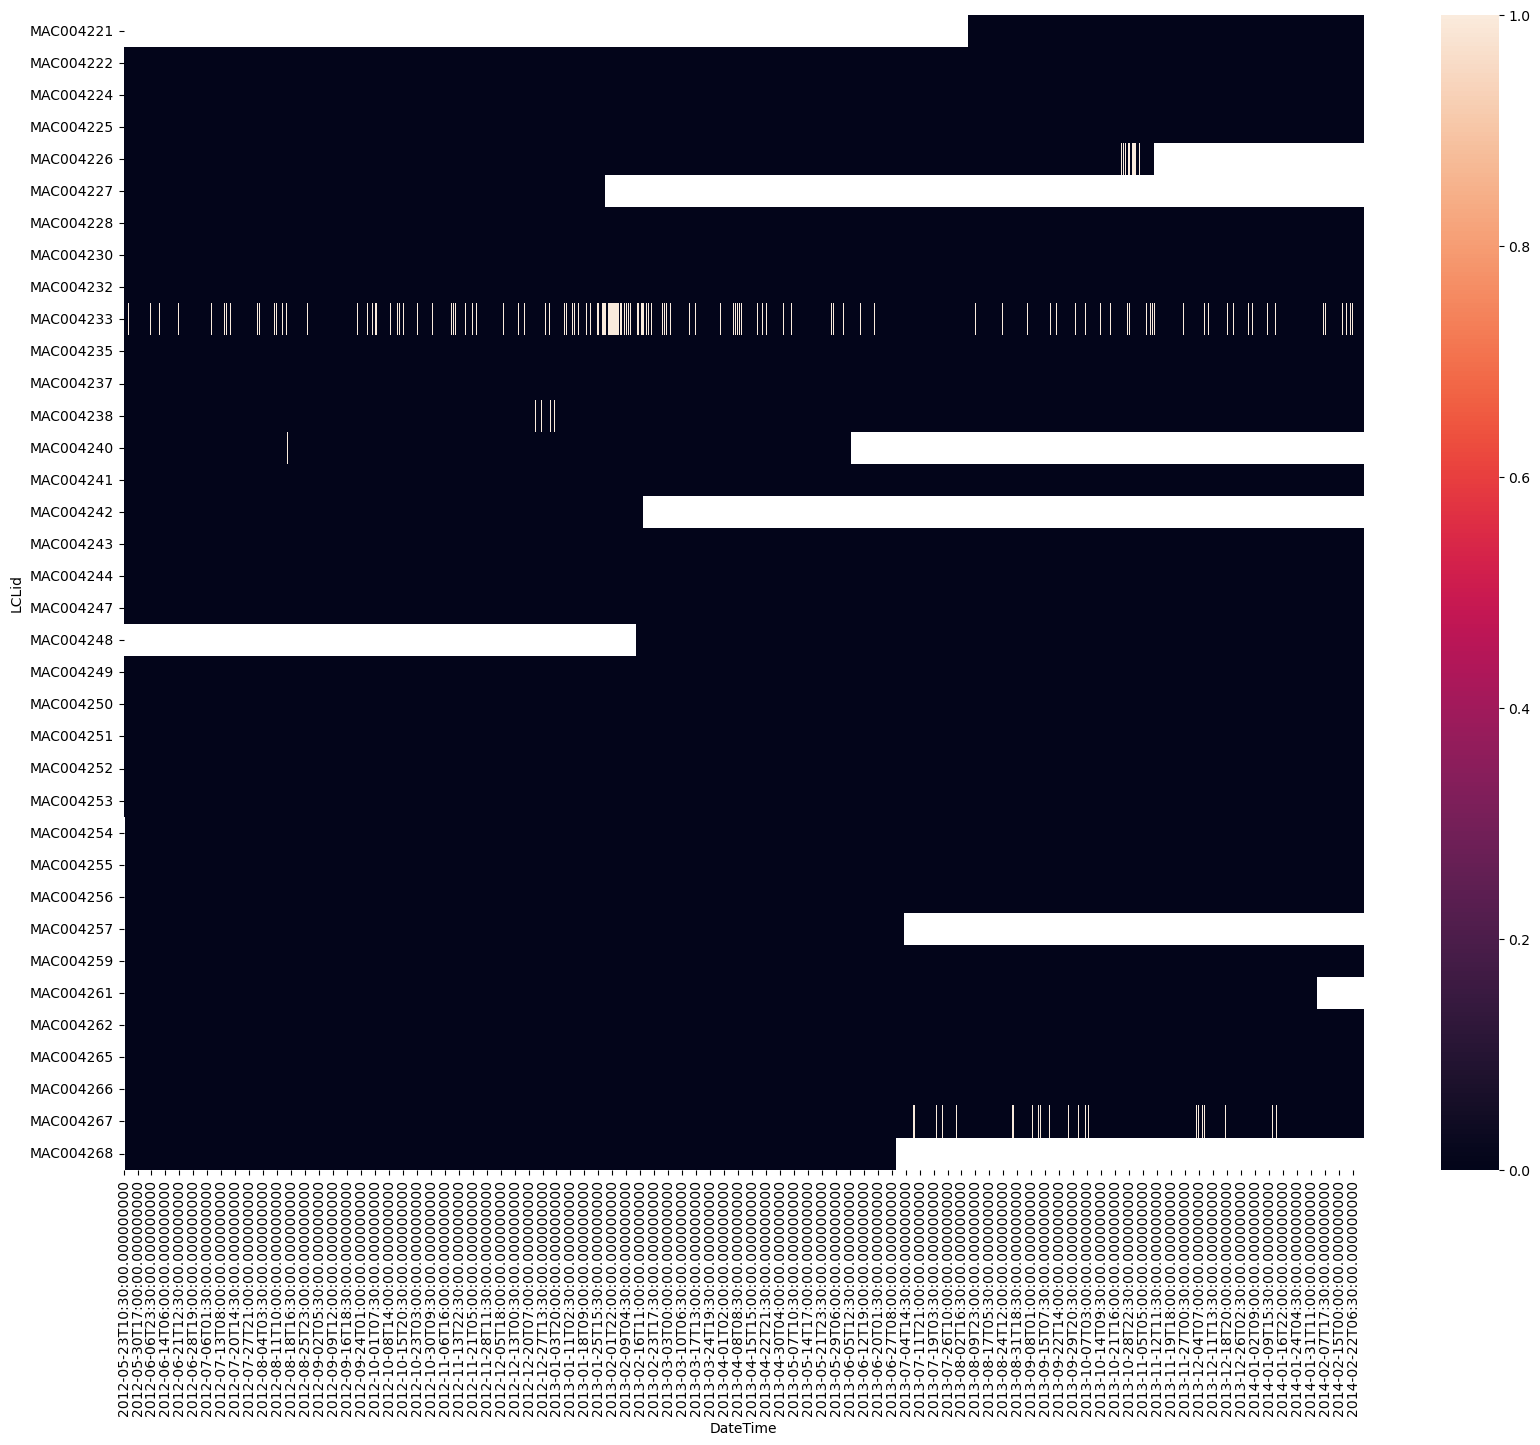

In [16]:
# visualize zeros in the dataset
df_interpol.info()
df_interpol['ZeroKWHperHH'] = df_interpol['KWHperHH'] == 0
pivot_table = pd.pivot_table(df_interpol, columns='DateTime', index='LCLid', values='ZeroKWHperHH')
plt.subplots(figsize=(20,15))

sns.heatmap(pivot_table)

Obervation: there are a handful of households that account all the zero value meter reads: MAC004233, MAC004226, MAC004267

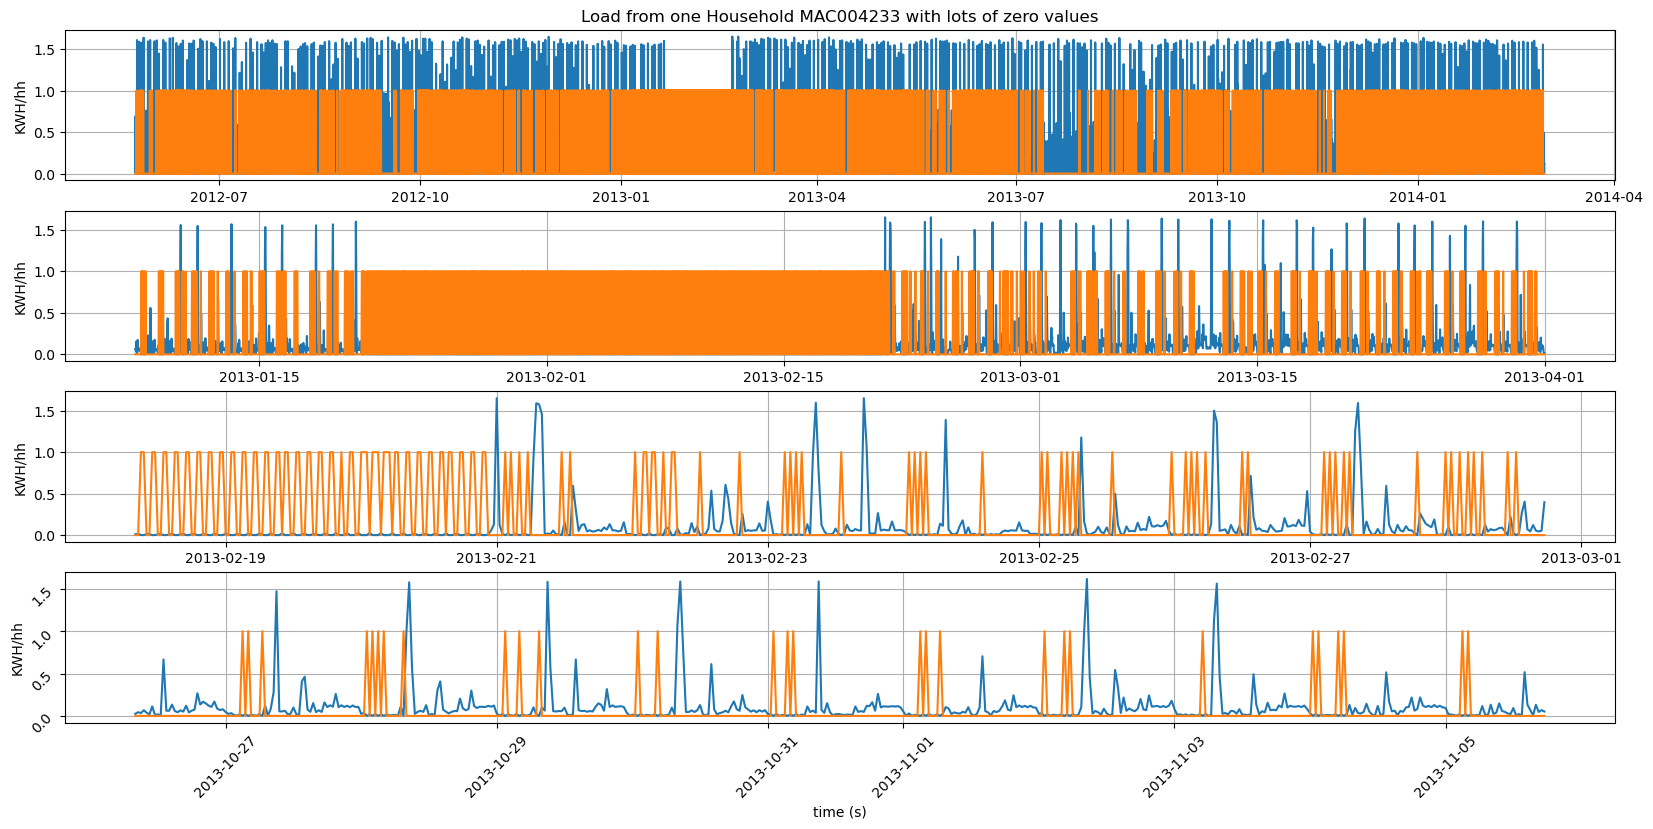

In [17]:
# investigate the meters with zero reads
MAC004233 = df_interpol.query("LCLid == 'MAC004233'")

fig, ax = plt.subplots(4,figsize=(20,9))

# plot whole ~2 years
ax[0].plot(MAC004233.DateTime, MAC004233.KWHperHH)
ax[0].plot(MAC004233.DateTime, MAC004233.ZeroKWHperHH)
ax[0].set(ylabel='KWH/hh',
       title='Load from one Household MAC004233 with lots of zero values')
plt.tick_params(rotation=45)
ax[0].grid()

# zoom in
ax[1].plot(MAC004233.DateTime[11000:15000], MAC004233.KWHperHH[11000:15000])
ax[1].plot(MAC004233.DateTime[11000:15000], MAC004233.ZeroKWHperHH[11000:15000])
ax[1].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[1].grid()

# zoom in more...
ax[2].plot(MAC004233.DateTime[13000:13500], MAC004233.KWHperHH[13000:13500])
ax[2].plot(MAC004233.DateTime[13000:13500], MAC004233.ZeroKWHperHH[13000:13500])
ax[2].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[2].grid()

# zoom in to a different part of the series...
ax[3].plot(MAC004233.DateTime[25000:25500], MAC004233.KWHperHH[25000:25500])
ax[3].plot(MAC004233.DateTime[25000:25500], MAC004233.ZeroKWHperHH[25000:25500])
ax[3].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[3].grid()

fig.savefig("MAC004233.png")
plt.show()

# Observation:

The zeros for MAC004233 seem legit - leaving them in

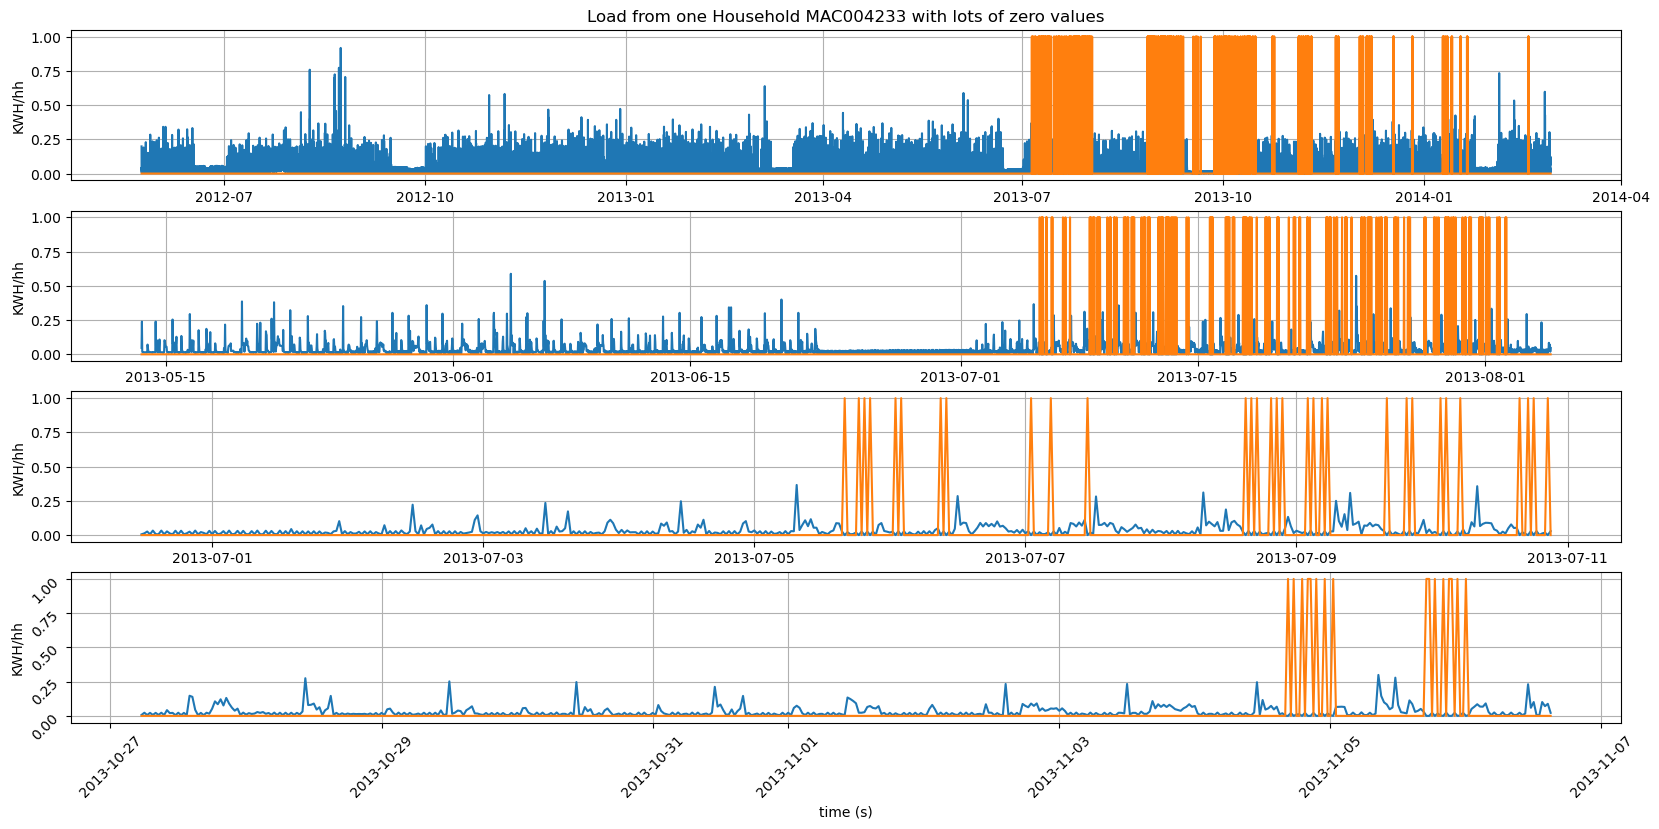

In [18]:
# investigate the meters with zero reads
MAC004267 = df_interpol.query("LCLid == 'MAC004267'")
fig, ax = plt.subplots(4,figsize=(20,9))

# plot whole ~2 years
ax[0].plot(MAC004267.DateTime, MAC004267.KWHperHH)
ax[0].plot(MAC004267.DateTime, MAC004267.ZeroKWHperHH)
ax[0].set(ylabel='KWH/hh',
       title='Load from one Household MAC004233 with lots of zero values')
plt.tick_params(rotation=45)
ax[0].grid()

# zoom in
ax[1].plot(MAC004267.DateTime[17000:21000], MAC004267.KWHperHH[17000:21000])
ax[1].plot(MAC004267.DateTime[17000:21000], MAC004267.ZeroKWHperHH[17000:21000])
ax[1].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[1].grid()

# zoom in more...
ax[2].plot(MAC004267.DateTime[19300:19800], MAC004267.KWHperHH[19300:19800])
ax[2].plot(MAC004267.DateTime[19300:19800], MAC004267.ZeroKWHperHH[19300:19800])
ax[2].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[2].grid()

# zoom in to a different part of the series...
ax[3].plot(MAC004267.DateTime[25000:25500], MAC004267.KWHperHH[25000:25500])
ax[3].plot(MAC004267.DateTime[25000:25500], MAC004267.ZeroKWHperHH[25000:25500])
ax[3].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[3].grid()

fig.savefig("MAC004233.png")
plt.show()

In [19]:
# visualize and handle outliers
d = df_interpol.copy()

# minumum and maximum timestamp for each house
print(d.groupby('LCLid').max().sort_values('DateTime'))
print(d.groupby('LCLid').min().sort_values('DateTime'))
print(d.groupby('LCLid').count().sort_values('DateTime'))

print(d.groupby('LCLid').agg(['min', 'max', 'count']))


                     DateTime  KWHperHH  ZeroKWHperHH
LCLid                                                
MAC004227 2013-01-29 00:00:00     2.430         False
MAC004242 2013-02-18 00:00:00     2.542         False
MAC004240 2013-06-05 23:30:00     1.784          True
MAC004268 2013-06-29 09:00:00     1.415         False
MAC004257 2013-07-04 00:00:00     3.254         False
MAC004226 2013-11-11 00:00:00     3.095          True
MAC004261 2014-02-04 00:00:00     2.720         False
MAC004251 2014-02-28 00:00:00     1.280         False
MAC004252 2014-02-28 00:00:00     1.934         False
MAC004253 2014-02-28 00:00:00     1.384         False
MAC004254 2014-02-28 00:00:00     1.552         False
MAC004256 2014-02-28 00:00:00     2.623         False
MAC004250 2014-02-28 00:00:00     1.557         False
MAC004259 2014-02-28 00:00:00     1.308         False
MAC004262 2014-02-28 00:00:00     1.999         False
MAC004265 2014-02-28 00:00:00     0.654          True
MAC004266 2014-02-28 00:00:0

In [20]:
# which house has the highest peak load?

# which house has the highest total aggregate load?

# how variable / predictable is the timing of the peak load

# how accurate is the next 24 hours forecast profile overall?

# how accurate is the peak load forecast in next 24 hours?

# normalize and standardize


In [21]:
# extract one smartmeter for plotting
sample = d.query("LCLid == 'MAC004233'")
sample

LCLid            DateTime  KWHperHH  ZeroKWHperHH
233576  MAC004233 2012-05-23 12:00:00     0.009         False
233577  MAC004233 2012-05-23 12:30:00     0.016         False
233578  MAC004233 2012-05-23 13:00:00     0.691         False
233579  MAC004233 2012-05-23 13:30:00     0.154         False
233580  MAC004233 2012-05-23 14:00:00     0.024         False
...           ...                 ...       ...           ...
264556  MAC004233 2014-02-27 22:00:00     0.116         False
264557  MAC004233 2014-02-27 22:30:00     0.123         False
264558  MAC004233 2014-02-27 23:00:00     0.036         False
264559  MAC004233 2014-02-27 23:30:00     0.037         False
264560  MAC004233 2014-02-28 00:00:00     0.020         False

[30985 rows x 4 columns]

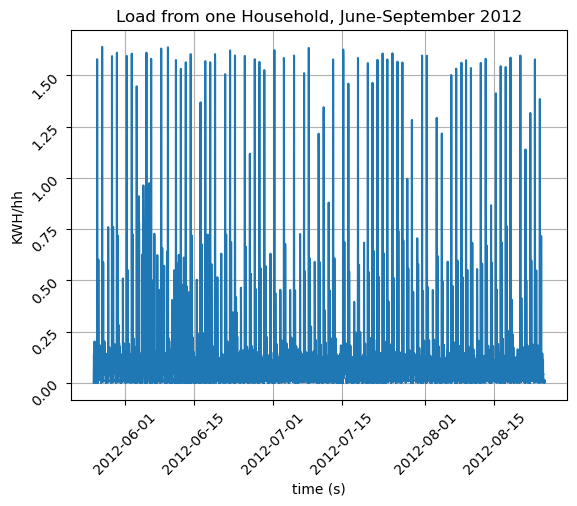

In [22]:
# Visualize load profile for one household meter
fig, ax = plt.subplots()
ax.plot(sample.iloc[100:4500,1], sample.iloc[100:4500,2])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Load from one Household, June-September 2012')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

In [23]:
sample.head()

LCLid            DateTime  KWHperHH  ZeroKWHperHH
233576  MAC004233 2012-05-23 12:00:00     0.009         False
233577  MAC004233 2012-05-23 12:30:00     0.016         False
233578  MAC004233 2012-05-23 13:00:00     0.691         False
233579  MAC004233 2012-05-23 13:30:00     0.154         False
233580  MAC004233 2012-05-23 14:00:00     0.024         False

In [24]:
sample.DateTime.dtype
sample.set_index('DateTime')

LCLid  KWHperHH  ZeroKWHperHH
DateTime                                              
2012-05-23 12:00:00  MAC004233     0.009         False
2012-05-23 12:30:00  MAC004233     0.016         False
2012-05-23 13:00:00  MAC004233     0.691         False
2012-05-23 13:30:00  MAC004233     0.154         False
2012-05-23 14:00:00  MAC004233     0.024         False
...                        ...       ...           ...
2014-02-27 22:00:00  MAC004233     0.116         False
2014-02-27 22:30:00  MAC004233     0.123         False
2014-02-27 23:00:00  MAC004233     0.036         False
2014-02-27 23:30:00  MAC004233     0.037         False
2014-02-28 00:00:00  MAC004233     0.020         False

[30985 rows x 3 columns]

In [25]:
# calculate sum of all loads
aggLoad = pd.DataFrame(columns=['DateTime', 'AggregateLoad'])
limit = 100
counter = 1
reportFreq = 1000
nUniqueTstamps = d.DateTime.unique().size
for tstamp in d.DateTime.unique():
    # print('tstamp: ', tstamp)
    tstampSum = d.loc[d['DateTime'] == tstamp].iloc[:,2].sum()
    row = {
    "DateTime": tstamp,
    "AggregateLoad": tstampSum
    }
    # print(row)
    # aggLoad = aggLoad.append(row, ignore_index=True)
    # Create an index for the DataFrame
    # index = pd.Index([1])
    index = pd.Index([1])
    
    # Create the DataFrame
    row_df = pd.DataFrame(row, index=index)

    # Concatenate `row_df` to `aggLoad`
    aggLoad = pd.concat([aggLoad, row_df], ignore_index=True)
    
    counter += 1
    
    if counter % reportFreq == 0:
        print('Progress: ', (counter / nUniqueTstamps)*100)
    
aggLoad

Progress:  3.2270556344391377
Progress:  6.454111268878275
Progress:  9.681166903317413
Progress:  12.90822253775655
Progress:  16.13527817219569
Progress:  19.362333806634826
Progress:  22.589389441073966
Progress:  25.8164450755131
Progress:  29.04350070995224
Progress:  32.27055634439138
Progress:  35.49761197883052
Progress:  38.72466761326965
Progress:  41.95172324770879
Progress:  45.17877888214793
Progress:  48.40583451658706
Progress:  51.6328901510262
Progress:  54.859945785465335
Progress:  58.08700141990448
Progress:  61.31405705434362
Progress:  64.54111268878276
Progress:  67.76816832322189
Progress:  70.99522395766104
Progress:  74.22227959210016
Progress:  77.4493352265393
Progress:  80.67639086097844
Progress:  83.90344649541758
Progress:  87.13050212985672
Progress:  90.35755776429586
Progress:  93.584613398735
Progress:  96.81166903317413


DateTime  AggregateLoad
0     2013-08-06 07:00:00          4.172
1     2013-08-06 07:30:00          4.793
2     2013-08-06 08:00:00          6.773
3     2013-08-06 08:30:00          5.659
4     2013-08-06 09:00:00          5.272
...                   ...            ...
30983 2013-08-06 04:30:00          3.510
30984 2013-08-06 05:00:00          3.468
30985 2013-08-06 05:30:00          3.895
30986 2013-08-06 06:00:00          5.811
30987 2013-08-06 06:30:00          4.907

[30988 rows x 2 columns]

In [26]:
aggLoad = aggLoad.sort_values(by=['DateTime'])
aggLoad = aggLoad.set_index('DateTime')
aggLoad.index.rename('DateTimeIndex', inplace=True)
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30988 entries, 2012-05-23 10:30:00 to 2014-02-28 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AggregateLoad  30988 non-null  float64
dtypes: float64(1)
memory usage: 484.2 KB


In [27]:
aggLoad['DateTime'] = aggLoad.index
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30988 entries, 2012-05-23 10:30:00 to 2014-02-28 00:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  30988 non-null  float64       
 1   DateTime       30988 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 726.3 KB


In [28]:
# inspect and fix records with zero load
# start with the aggregated records with zero load
AggZeros = aggLoad.query("AggregateLoad == 0")
AggZeros



Empty DataFrame
Columns: [AggregateLoad, DateTime]
Index: []

Observation: Some of the timestamps are not exactly on the half-hour
Question: How many of the timestamps are not exactly on the half-hour?

In [29]:
# inspect and fix records with zero load
# look at the raw records with zero load
# RawZeros = d.query("'KWH/hh (per half hour)' == 0")
# RawZeros

In [30]:
# inspect and fix records not exactly on the half-hour
offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
# aggLoad["DateTime"].dt.hour > 30
print('Records not exactly on the half-hour: ', offRecs)
print(offRecs.info())

# delete records not exactly on the half-hour
aggLoad = aggLoad.drop(offRecs.index)

offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)

Records not exactly on the half-hour:  Empty DataFrame
Columns: [AggregateLoad, DateTime]
Index: []
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  0 non-null      float64       
 1   DateTime       0 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 0.0 bytes
None
Records not exactly on the half-hour:  Empty DataFrame
Columns: [AggregateLoad, DateTime]
Index: []


In [31]:
# check for missing records in the aggregate load time series
# create reference time series
minTimestamp = aggLoad.index.min()
maxTimestamp = aggLoad.index.max()

print('minTimestamp: ', minTimestamp)
print('maxTimestamp: ', maxTimestamp)

date_range = pd.date_range(minTimestamp, maxTimestamp, freq='30Min')
reference_df = pd.DataFrame(np.random.randint(1, 20, (date_range.shape[0], 1)))
reference_df.index = date_range  # set index

print('reference index length: ', reference_df.shape)
print('aggLoad index length: ', aggLoad.shape)

print('reference_df: ', reference_df)
print('aggLoad: ', aggLoad)

print('reference index: ', reference_df.index)
print('aggLoad index: ', aggLoad.index)

# check for missing datetimeindex values based on reference index (with all values)
missing_dates = reference_df.index[~reference_df.index.isin(aggLoad.index)]

print('missing_dates: ', missing_dates)

minTimestamp:  2012-05-23 10:30:00
maxTimestamp:  2014-02-28 00:00:00
reference index length:  (30988, 1)
aggLoad index length:  (30988, 2)
reference_df:                        0
2012-05-23 10:30:00   1
2012-05-23 11:00:00  17
2012-05-23 11:30:00  10
2012-05-23 12:00:00   4
2012-05-23 12:30:00   9
...                  ..
2014-02-27 22:00:00   2
2014-02-27 22:30:00  10
2014-02-27 23:00:00   3
2014-02-27 23:30:00   9
2014-02-28 00:00:00  17

[30988 rows x 1 columns]
aggLoad:                       AggregateLoad            DateTime
DateTimeIndex                                         
2012-05-23 10:30:00          0.382 2012-05-23 10:30:00
2012-05-23 11:00:00          1.146 2012-05-23 11:00:00
2012-05-23 11:30:00          1.567 2012-05-23 11:30:00
2012-05-23 12:00:00          3.183 2012-05-23 12:00:00
2012-05-23 12:30:00          2.988 2012-05-23 12:30:00
...                            ...                 ...
2014-02-27 22:00:00          8.790 2014-02-27 22:00:00
2014-02-27 22:30:00       

In [32]:
# check the regularity of the observations (time between observations)
# print(pd.infer_freq(train_data.DateTime))
aggLoad.index.to_series().diff().value_counts()

0 days 00:30:00    30987
Name: DateTimeIndex, dtype: int64

                     AggregateLoad            DateTime
DateTimeIndex                                         
2012-05-23 10:30:00          0.382 2012-05-23 10:30:00
2012-05-23 11:00:00          1.146 2012-05-23 11:00:00
2012-05-23 11:30:00          1.567 2012-05-23 11:30:00
2012-05-23 12:00:00          3.183 2012-05-23 12:00:00
2012-05-23 12:30:00          2.988 2012-05-23 12:30:00
...                            ...                 ...
2014-02-27 22:00:00          8.790 2014-02-27 22:00:00
2014-02-27 22:30:00          7.083 2014-02-27 22:30:00
2014-02-27 23:00:00          6.616 2014-02-27 23:00:00
2014-02-27 23:30:00          5.552 2014-02-27 23:30:00
2014-02-28 00:00:00          4.845 2014-02-28 00:00:00

[30988 rows x 2 columns]


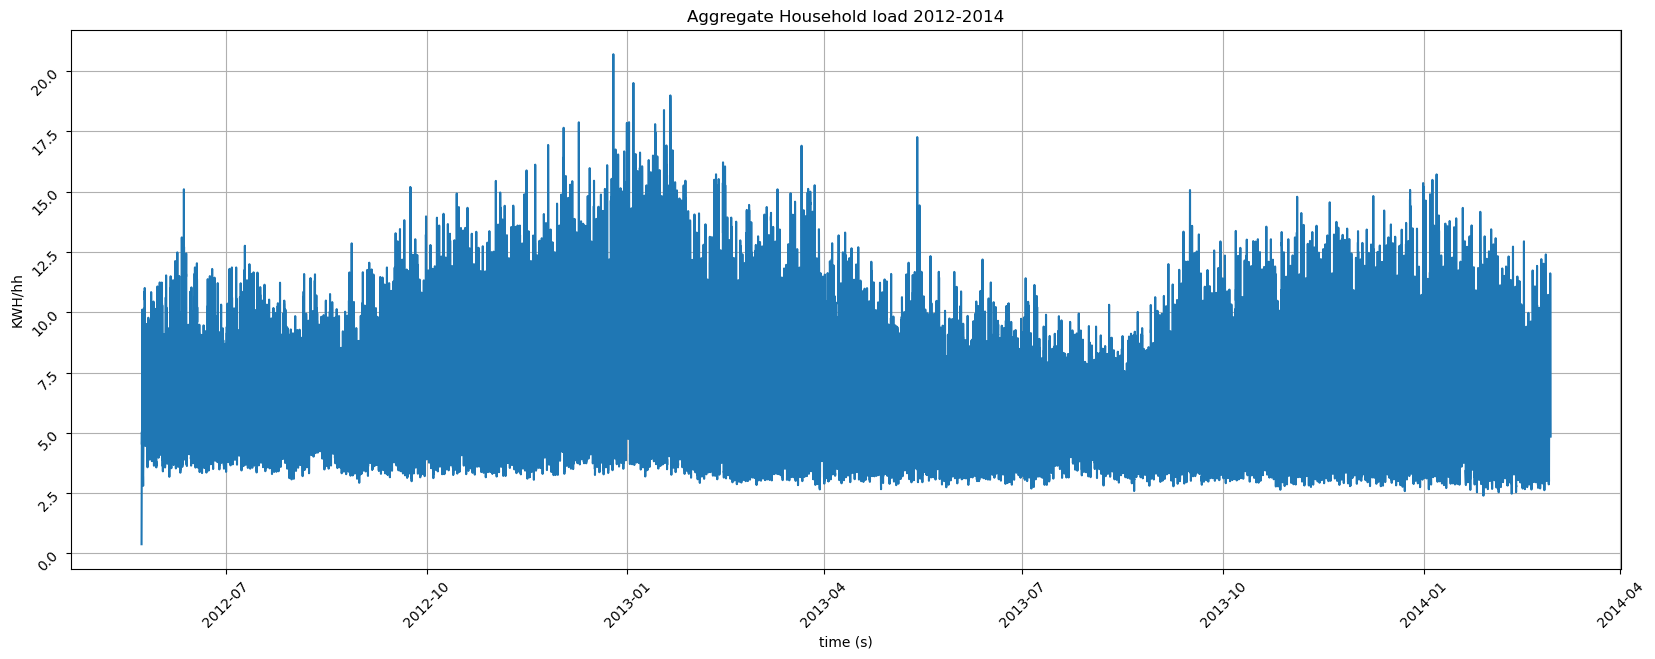

In [33]:
print(aggLoad)

fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime, aggLoad.AggregateLoad)

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load 2012-2014')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

In [34]:
aggLoad.head()


AggregateLoad            DateTime
DateTimeIndex                                         
2012-05-23 10:30:00          0.382 2012-05-23 10:30:00
2012-05-23 11:00:00          1.146 2012-05-23 11:00:00
2012-05-23 11:30:00          1.567 2012-05-23 11:30:00
2012-05-23 12:00:00          3.183 2012-05-23 12:00:00
2012-05-23 12:30:00          2.988 2012-05-23 12:30:00

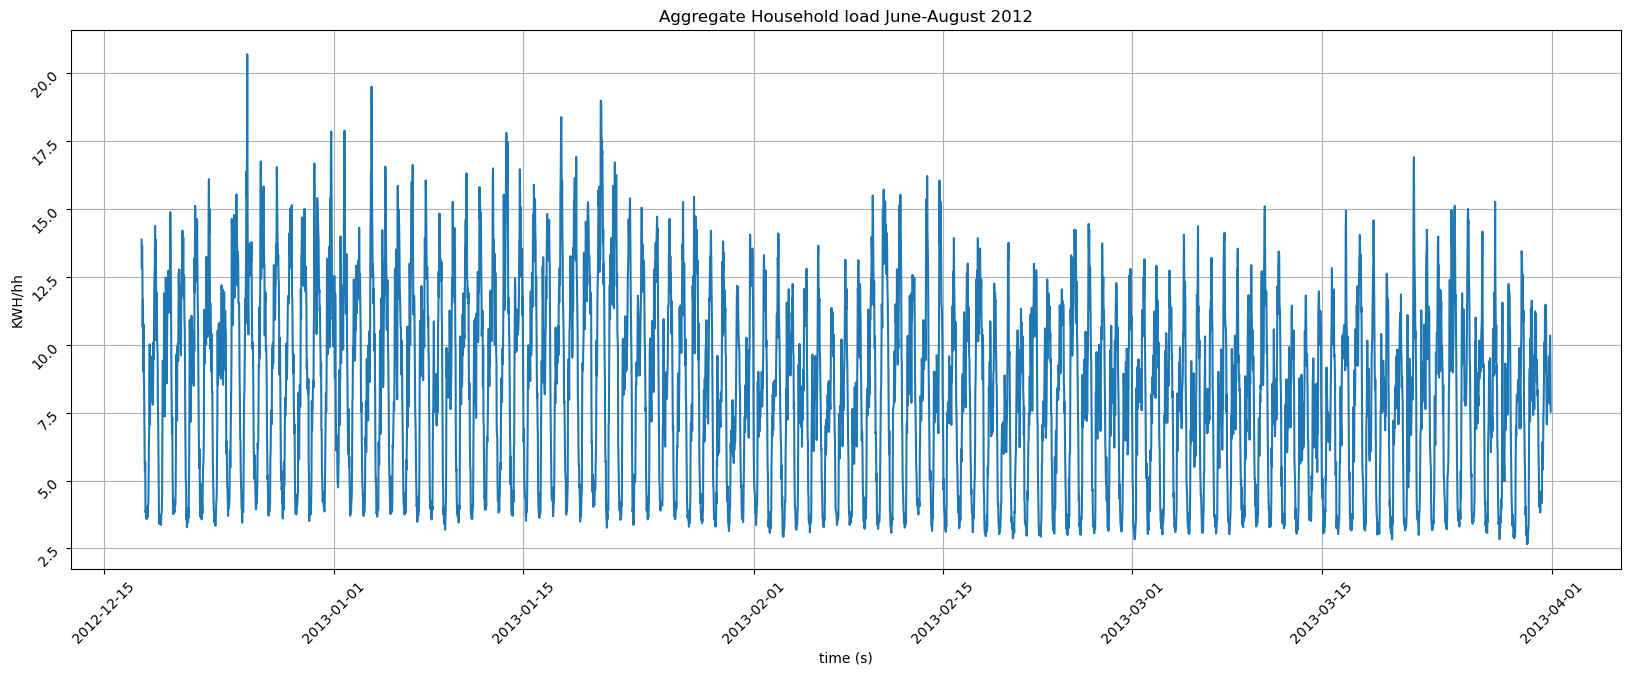

In [35]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[10000:15000], aggLoad.AggregateLoad[10000:15000])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load June-August 2012')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

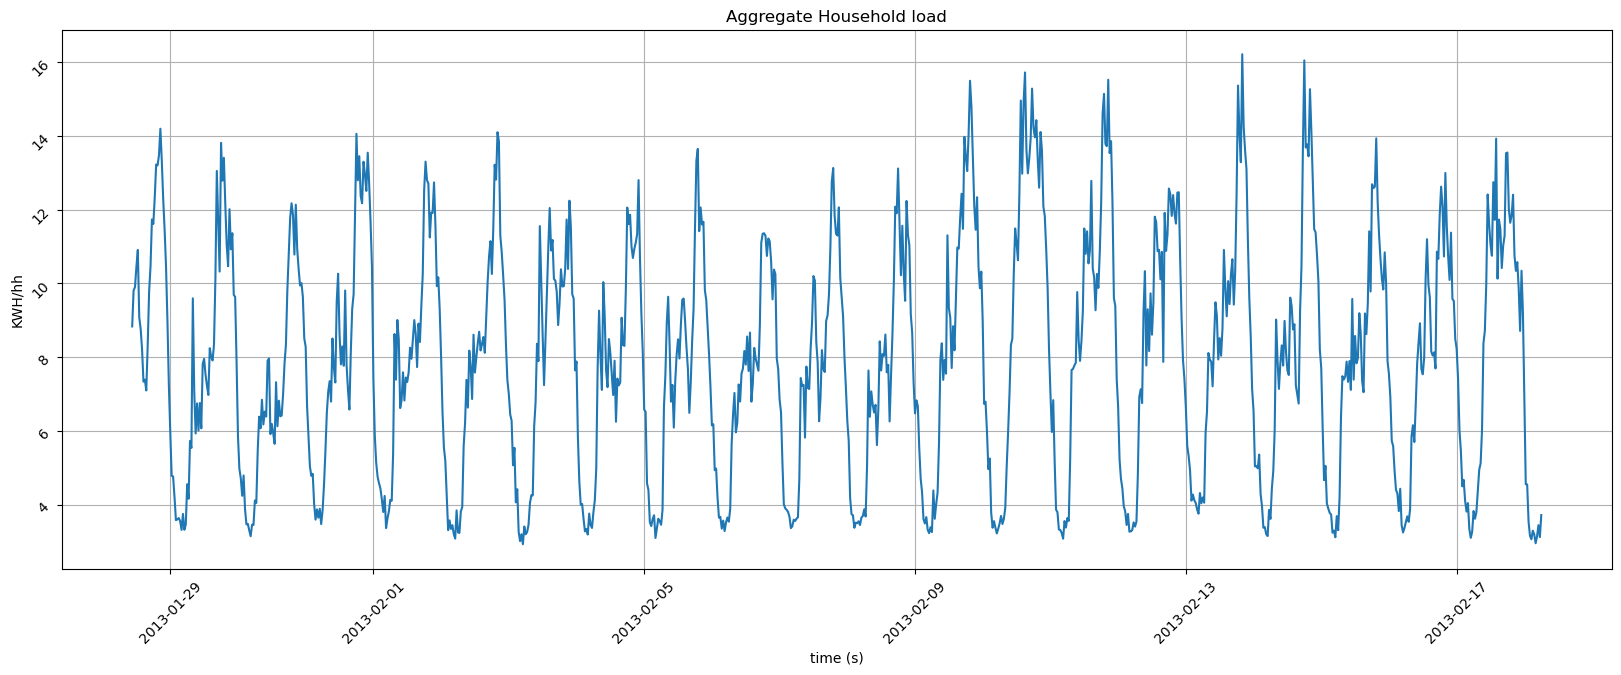

In [36]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[12000:13000], aggLoad.AggregateLoad[12000:13000])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

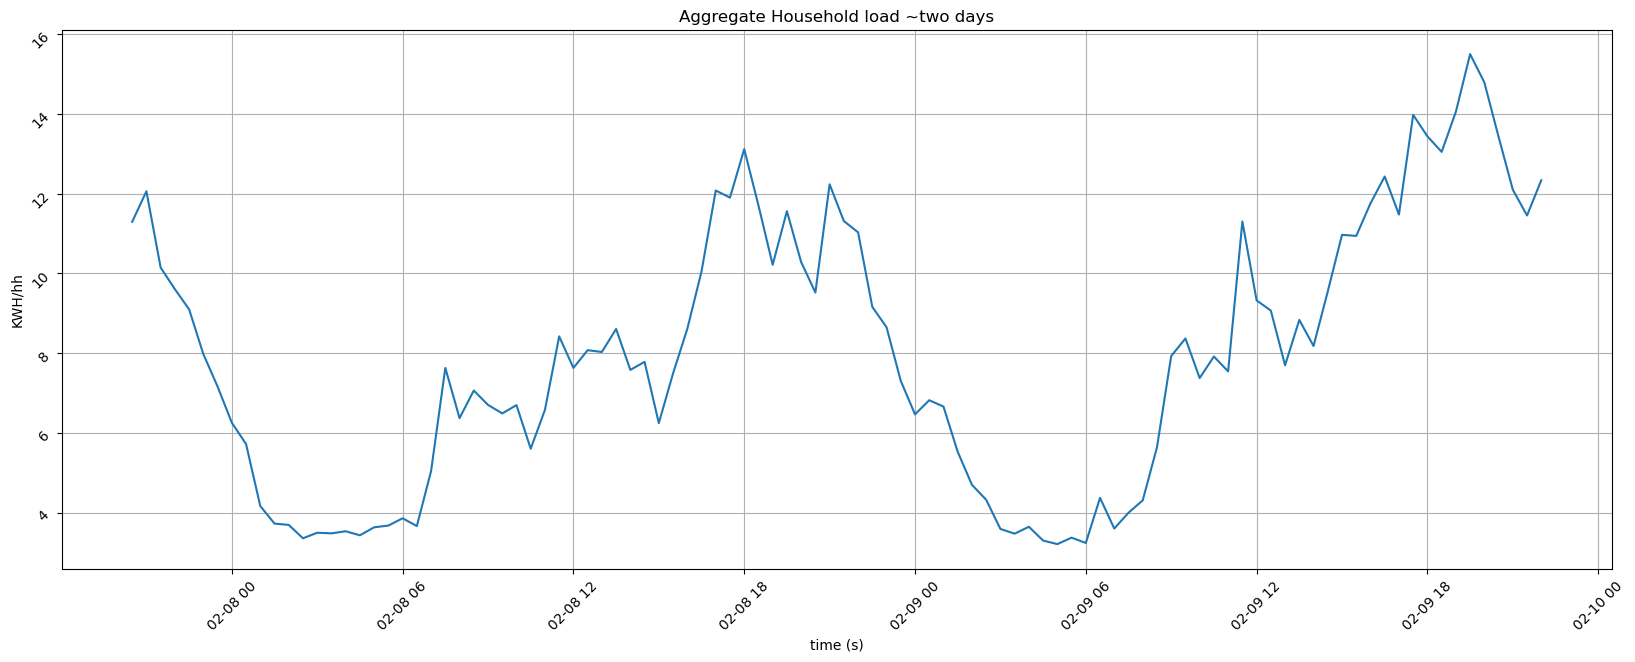

In [37]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[12500:12600], aggLoad.AggregateLoad[12500:12600])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load ~two days')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

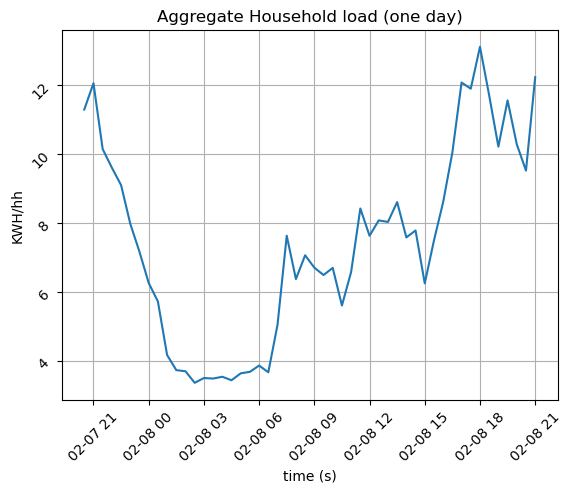

In [38]:
fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime[12500:12550], aggLoad.AggregateLoad[12500:12550])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load (one day)')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

In [39]:
def prediction_plot(testY, test_predict):
      len_prediction=[x for x in range(len(testY))]
      plt.figure(figsize=(20,5))
      plt.plot(len_prediction, testY, marker='.', label="actual")
      plt.plot(len_prediction, test_predict, 'r', label="prediction")
      plt.tight_layout()
      sns.despine(top=True)
      plt.subplots_adjust(left=0.07)
      plt.ylabel('KWH per half hour', size=15)
      plt.xlabel('Time step', size=15)
      plt.legend(fontsize=15)
      plt.show();

# Use a naive persistence model as baseline to compare more sophisticated models
Use a 1 week persistence

Georgios Tziolis, Chrysovalantis Spanias, Maria Theodoride, Spyros Theocharides, Javier Lopez-Lorente, Andreas Livera, George Makrides, George E. Georghiou,

Short-term electric net load forecasting for solar-integrated distribution systems based on Bayesian neural networks and statistical post-processing,

Energy,
Volume 271,
2023,
127018,
ISSN 0360-5442,

https://doi.org/10.1016/j.energy.2023.127018.

In [40]:
# Naive 1 week persistence model
NaiveForecast = aggLoad.AggregateLoad.copy()

OneWeekNPeriods = 48 * 7

NaiveForecast[:OneWeekNPeriods] = np.nan

for i in range(OneWeekNPeriods, len(aggLoad.AggregateLoad)):
    NaiveForecast[i] = aggLoad.AggregateLoad[i - OneWeekNPeriods]
    


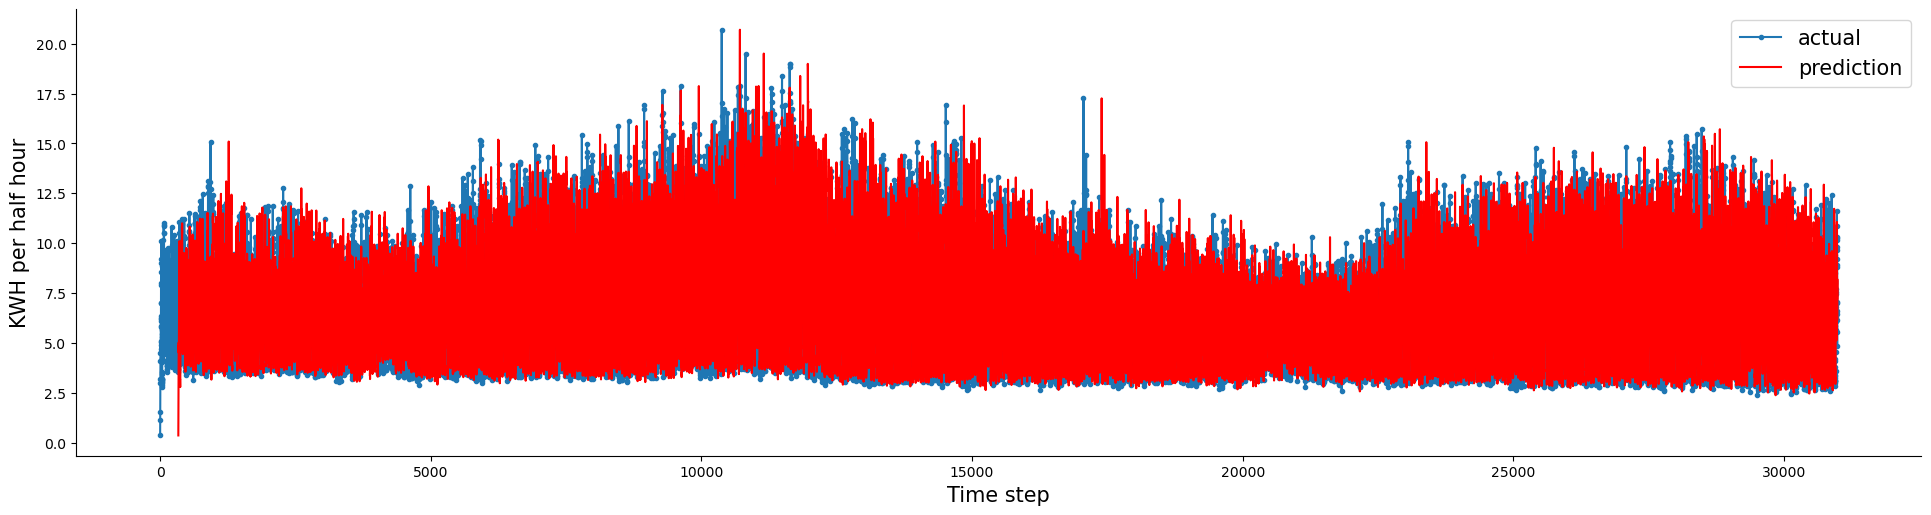

In [41]:
# visualize naive forecast
prediction_plot(aggLoad.AggregateLoad, NaiveForecast)

In [42]:
# calculate error for naive model
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print('Naive Root Mean Squared Error(RMSE): %.2f; Naive Mean Absolute Error(MAE) : %.2f; Naive Mean Absolute Percantage Error(MAPE) : %.2f '
      % (np.sqrt(mean_squared_error(aggLoad.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])),
         mean_absolute_error(aggLoad.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:]),
         mean_absolute_percentage_error(aggLoad.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])))


Naive Root Mean Squared Error(RMSE): 1.45; Naive Mean Absolute Error(MAE) : 1.06; Naive Mean Absolute Percantage Error(MAPE) : 0.15 


In [43]:
# ADF Test function
import statsmodels.tsa.stattools as smt
def adf_test(series):
 result = smt.adfuller(series.dropna())
 print('ADF Statistic: %f' % result[0])
 print('p-value: %f' % result[1])
 return result

In [44]:
adf_test(aggLoad.AggregateLoad)

ADF Statistic: -5.996124
p-value: 0.000000


(-5.996123842962695,
 1.6999806538622077e-07,
 51,
 30936,
 {'1%': -3.4305613991041852,
  '5%': -2.8616334327936723,
  '10%': -2.566819731406787},
 81156.13560043977)

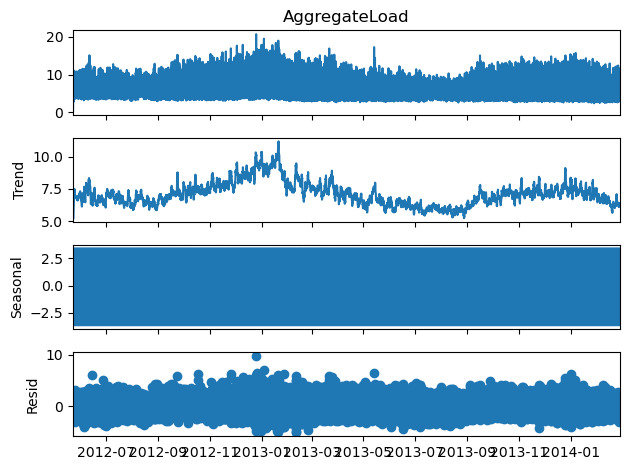

In [45]:
import statsmodels.tsa.seasonal as sts

components = sts.seasonal_decompose(aggLoad.AggregateLoad, period=48) # 48 = one day
components.plot()
plt.show()

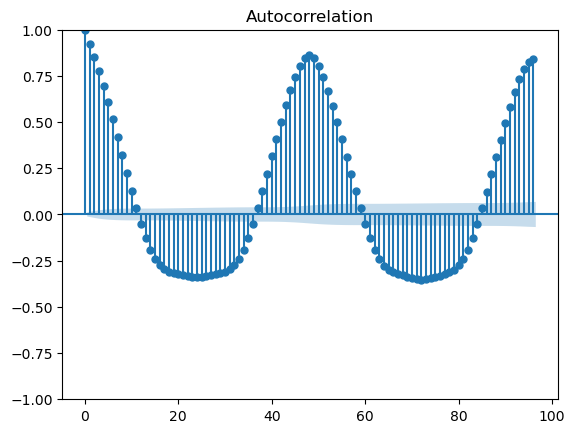

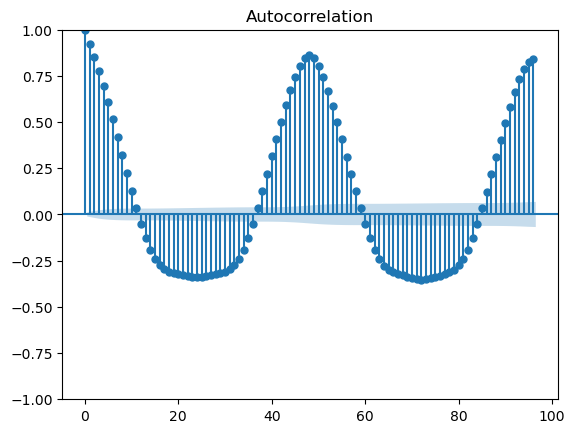

In [46]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(aggLoad.AggregateLoad, lags = 96) 


In [47]:
! pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.5 MB/s eta 0:00:00


find best parameters for ARIMA
import pmdarima as pm
model = pm.auto_arima(aggLoad.AggregateLoad, start_p=1, start_q=1,
                      test='adf',       
use adftest to find optimal 'd'
                      max_p=3, max_q=3, 
maximum p=3 and q=3
                      m=17532,              
periodicity of 48 months as the data timeline is in h
                      d=None,           
let the model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

In [48]:
# print(model.summary())

In [49]:
# Split the time series data into train, test, and validation datasets
train_size = int(len(aggLoad) * 0.7)  # 70% for training
test_size = int(len(aggLoad) * 0.2)   # 20% for testing
val_size = len(aggLoad) - train_size - test_size  # Remaining for validation

train_data = aggLoad[:train_size]
test_data = aggLoad[train_size:train_size+test_size]
val_data = aggLoad[train_size+test_size:]

print('train_data.head()', train_data.head())
print('test_data.head()', test_data.head())
print('val_data.head()', val_data.head())
print(train_data.info())

train_data.head()                      AggregateLoad            DateTime
DateTimeIndex                                         
2012-05-23 10:30:00          0.382 2012-05-23 10:30:00
2012-05-23 11:00:00          1.146 2012-05-23 11:00:00
2012-05-23 11:30:00          1.567 2012-05-23 11:30:00
2012-05-23 12:00:00          3.183 2012-05-23 12:00:00
2012-05-23 12:30:00          2.988 2012-05-23 12:30:00
test_data.head()                      AggregateLoad            DateTime
DateTimeIndex                                         
2013-08-18 08:00:00          6.144 2013-08-18 08:00:00
2013-08-18 08:30:00          6.288 2013-08-18 08:30:00
2013-08-18 09:00:00          6.219 2013-08-18 09:00:00
2013-08-18 09:30:00          6.255 2013-08-18 09:30:00
2013-08-18 10:00:00          6.169 2013-08-18 10:00:00
val_data.head()                      AggregateLoad            DateTime
DateTimeIndex                                         
2013-12-25 10:30:00          7.703 2013-12-25 10:30:00
2013-12-25 11:

Create an ARIMA algorithm baseline to assess other models against 

# Create a Deep Learning time series forecasting model using Keras

In [50]:
import tensorflow as tf
from tensorflow import keras

def convert2matrix(data_arr, look_back):
   X, Y =[], []
   for i in range(len(data_arr)-look_back):
       d=i+look_back  
       X.append(data_arr[i:d,])
       Y.append(data_arr[d,])
   return np.array(X), np.array(Y)

In [51]:
# RNN
# work with a copy of the dataset
df1 = aggLoad.copy()
# print(df1.head())
df1 = df1.drop(columns=['DateTime'])
print(df1.head())

# prepare the data
train,test = df1.values[0:train_size,:], df1.values[train_size:train_size+test_size,:]
look_back = 48 # create window size
test = np.append(test,np.repeat(test[-1,], look_back))
train = np.append(train,np.repeat(train[-1,],look_back))
trainX,trainY =convert2matrix(train,look_back)
testX,testY =convert2matrix(test,look_back)
# reshape input to be [samples, window size, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


print('trainX:\n', trainX.shape, trainX.dtype)


                     AggregateLoad
DateTimeIndex                     
2012-05-23 10:30:00          0.382
2012-05-23 11:00:00          1.146
2012-05-23 11:30:00          1.567
2012-05-23 12:00:00          3.183
2012-05-23 12:30:00          2.988
trainX:
 (21691, 1, 48) float64


In [52]:
# define the RNN model architecture
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import EarlyStopping
def model_rnn(look_back):
  model=Sequential()
  model.add(SimpleRNN(units=16, input_shape=(1,look_back), activation="relu"))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
  return model

In [53]:
# fit the RNN model
model=model_rnn(look_back)

history=model.fit(trainX,trainY, epochs=100, batch_size=30, verbose=1, validation_data=(testX,testY),callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)

Epoch 1/100
724/724 [==============================] - 3s 3ms/step - loss: 2.4593 - mse: 2.4593 - mae: 1.1367 - val_loss: 1.2755 - val_mse: 1.2755 - val_mae: 0.8451
Epoch 2/100
724/724 [==============================] - 2s 2ms/step - loss: 1.0836 - mse: 1.0836 - mae: 0.7822 - val_loss: 1.0948 - val_mse: 1.0948 - val_mae: 0.7827
Epoch 3/100
724/724 [==============================] - 1s 2ms/step - loss: 0.9719 - mse: 0.9719 - mae: 0.7384 - val_loss: 0.9873 - val_mse: 0.9873 - val_mae: 0.7348
Epoch 4/100
724/724 [==============================] - 2s 2ms/step - loss: 0.9102 - mse: 0.9102 - mae: 0.7133 - val_loss: 0.9480 - val_mse: 0.9480 - val_mae: 0.7143
Epoch 5/100
724/724 [==============================] - 2s 2ms/step - loss: 0.8770 - mse: 0.8770 - mae: 0.6988 - val_loss: 0.9658 - val_mse: 0.9658 - val_mae: 0.7199
Epoch 6/100
724/724 [==============================] - 1s 2ms/step - loss: 0.8582 - mse: 0.8582 - mae: 0.6912 - val_loss: 0.9485 - val_mse: 0.9485 - val_mae: 0.7138
Epoch 7/10

In [54]:
# function for plotting the train and test loss curves
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

194/194 [==============================] - 0s 1ms/step
Train Root Mean Squared Error(RMSE): 1.06; Train Mean Absolute Error(MAE) : 0.78 
Test Root Mean Squared Error(RMSE): 1.02; Test Mean Absolute Error(MAE) : 0.76 


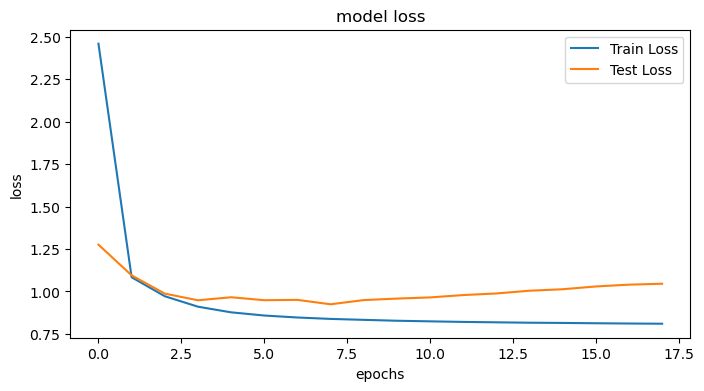

In [55]:
# predict on the train and test datasets
from sklearn.metrics import mean_squared_error, mean_absolute_error
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f '
      % (np.sqrt(mean_squared_error(trainY, train_predict)), mean_absolute_error(trainY, train_predict[:,0])))
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
      % (np.sqrt(mean_squared_error(testY, test_predict[:,0])), mean_absolute_error(testY, test_predict[:,0])))
model_loss(history)

testY:
 (6197,) [7.605     6.852     7.6800001 ... 8.887     8.887     8.887    ]
test_predict:
 (6197, 1) [[6.0659976]
 [6.8231745]
 [6.441062 ]
 ...
 [8.212803 ]
 [8.030807 ]
 [8.266257 ]]


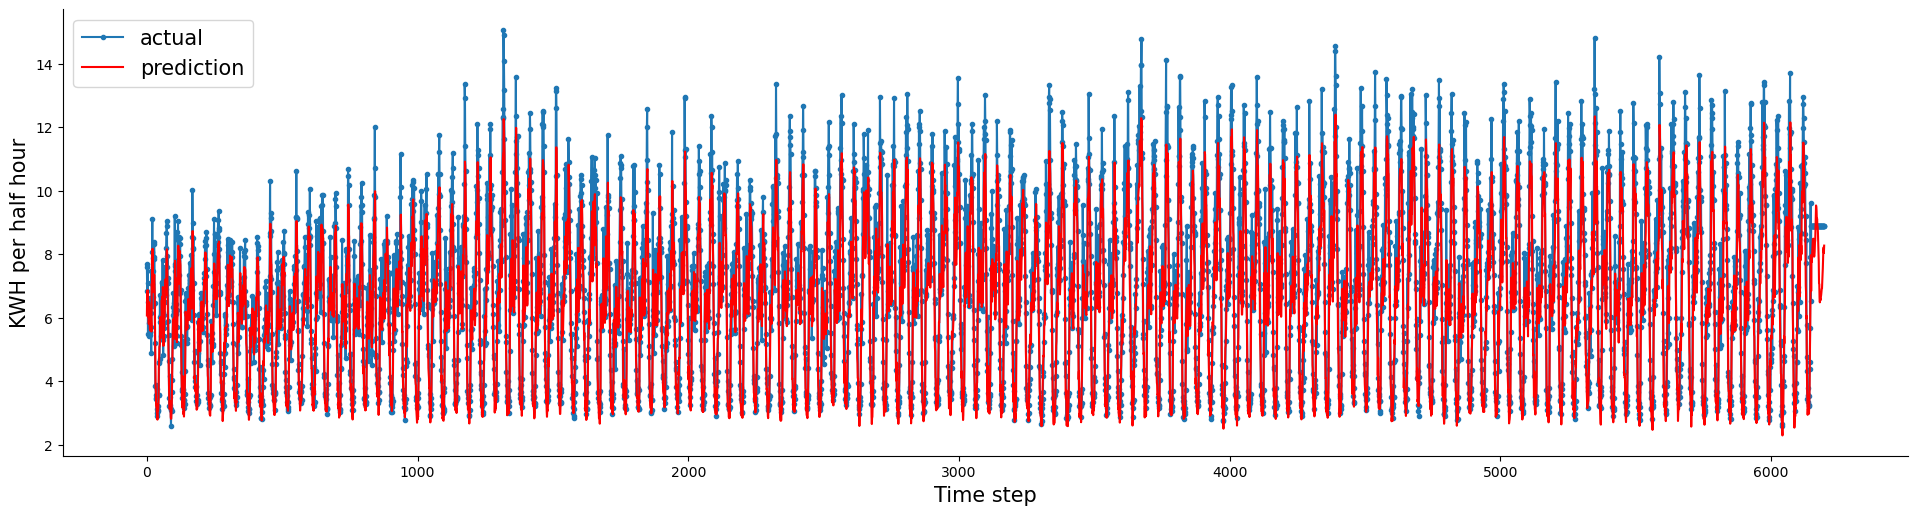

In [56]:
# plot actuals and predictions for the whole test set
print('testY:\n', testY.shape, testY)
print('test_predict:\n', test_predict.shape, test_predict)
prediction_plot(testY, test_predict)



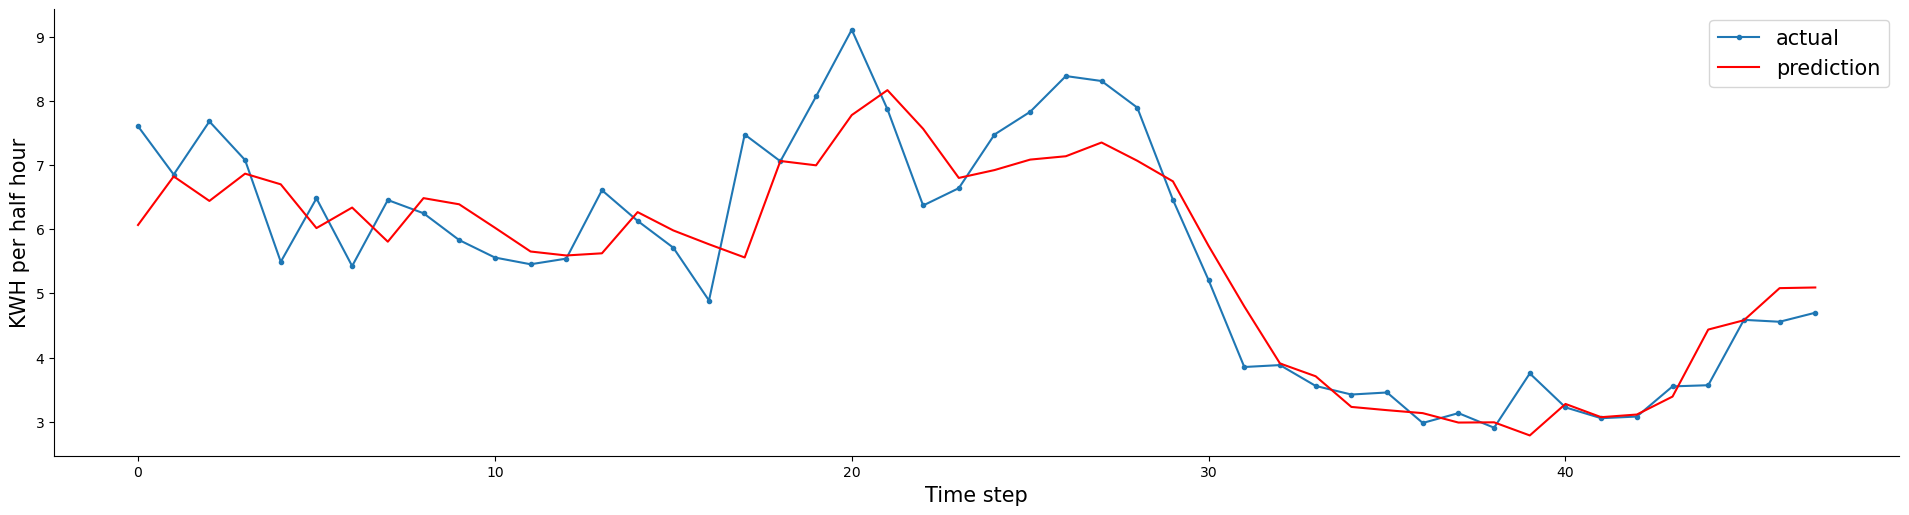

In [57]:
# plot actuals and RNN predictions for the first day of the test set
prediction_plot(testY[0:48], test_predict[0:48])


In [58]:
# LSTM

In [59]:
# CNN-LSTM

# Summary of errors for naive and RNN


In [60]:
print('Naive Root Mean Squared Error(RMSE): %.2f; Naive Mean Absolute Error(MAE) : %.2f; Naive Mean Absolute Percantage Error(MAPE) : %.2f '
      % (np.sqrt(mean_squared_error(aggLoad.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])),
         mean_absolute_error(aggLoad.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:]),
         mean_absolute_percentage_error(aggLoad.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])))
print('RNN Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f '
      % (np.sqrt(mean_squared_error(trainY, train_predict)), mean_absolute_error(trainY, train_predict[:,0])))
print('RNN Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
      % (np.sqrt(mean_squared_error(testY, test_predict[:,0])), mean_absolute_error(testY, test_predict[:,0])))

# to-do: create nice graphic for this

Naive Root Mean Squared Error(RMSE): 1.45; Naive Mean Absolute Error(MAE) : 1.06; Naive Mean Absolute Percantage Error(MAPE) : 0.15 
RNN Train Root Mean Squared Error(RMSE): 1.06; Train Mean Absolute Error(MAE) : 0.78 
RNN Test Root Mean Squared Error(RMSE): 1.02; Test Mean Absolute Error(MAE) : 0.76 


# Plot of naive, RNN and actuals

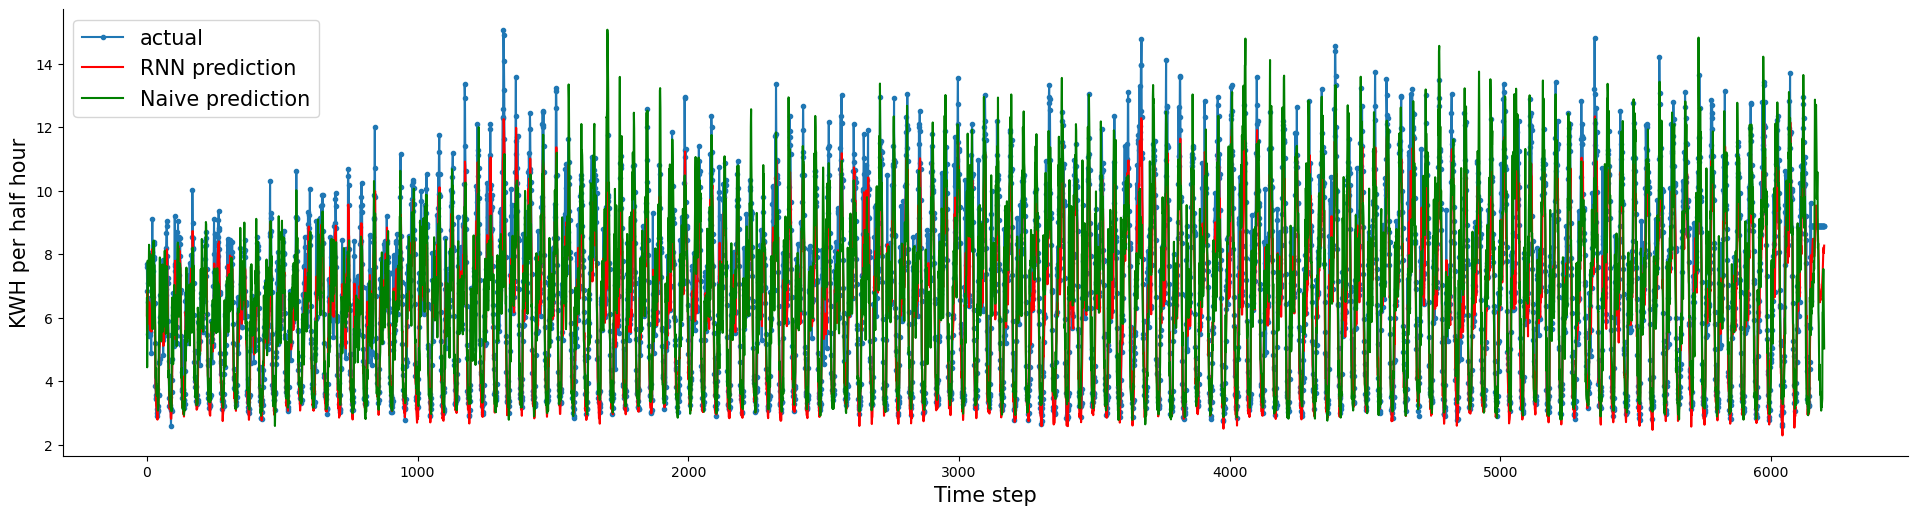

In [61]:
      len_prediction=[x for x in range(len(testY))]
      plt.figure(figsize=(20,5))
      plt.plot(len_prediction, testY, marker='.', label="actual")
      plt.plot(len_prediction, test_predict, 'r', label="RNN prediction")
      plt.plot(len_prediction, NaiveForecast[train_size:train_size+test_size], 'g', label="Naive prediction")
        
      plt.tight_layout()
      sns.despine(top=True)
      plt.subplots_adjust(left=0.07)
      plt.ylabel('KWH per half hour', size=15)
      plt.xlabel('Time step', size=15)
      plt.legend(fontsize=15)
      plt.show();

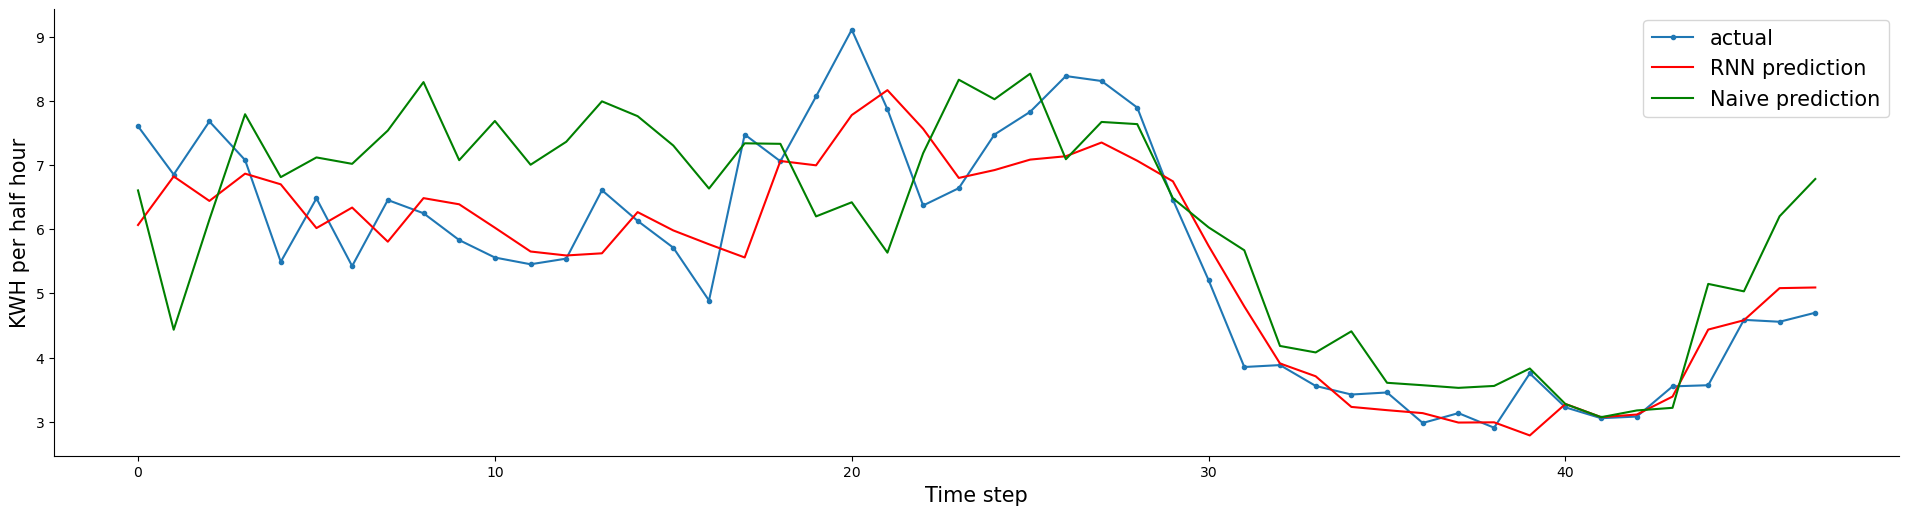

In [62]:
      len_prediction=[x for x in range(len(testY[0:48]))]
      plt.figure(figsize=(20,5))
      plt.plot(len_prediction, testY[0:48], marker='.', label="actual")
      plt.plot(len_prediction, test_predict[0:48], 'r', label="RNN prediction")
      plt.plot(len_prediction, NaiveForecast[train_size:train_size+48], 'g', label="Naive prediction")
        
      plt.tight_layout()
      sns.despine(top=True)
      plt.subplots_adjust(left=0.07)
      plt.ylabel('KWH per half hour', size=15)
      plt.xlabel('Time step', size=15)
      plt.legend(fontsize=15)
      plt.show();

Use AutoGluon AutoML with London dataset

In [63]:
# install AutoGluon AutoML
!pip install autogluon
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.7/285.7 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.3/372.3 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.3 MB

In [64]:
# AutoGluon specific data preparation
# work with a copy of the split datasets..."ag_" prefix stands for AutoGluon
ag_train_data = train_data.copy()
ag_test_data = test_data.copy()
ag_val_data = val_data.copy()

# AutoGluon requires an ItemID Column, so adding one...
ag_train_data['item_id'] = 'LoadSum'
ag_train_data = train_data.astype({"item_id": str})
ag_test_data['item_id'] = 'LoadSum'
ag_test_data = test_data.astype({"item_id": str})
ag_val_data['item_id'] = 'LoadSum'
ag_val_data = val_data.astype({"item_id": str})

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6                                                                                             │
│    7 # AutoGluon requires an ItemID Column, so adding one...                                     │
│    8 ag_train_data['item_id'] = 'LoadSum'                                                        │
│ ❱  9 ag_train_data = train_data.astype({"item_id": str})                                         │
│   10 ag_test_data['item_id'] = 'LoadSum'                                                         │
│   11 ag_test_data = test_data.astype({"item_id": str})                                           │
│   12 ag_val_data['item_id'] = 'LoadSum'                                                          │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/pandas/core/generic.py:6212 in astype                    │
│                                                                                                  │
│    6209 │   │   │                                                                                │
│    6210 │   │   │   for col_name in dtype_ser.index:                                             │
│    6211 │   │   │   │   if col_name not in self:                                                 │
│ ❱  6212 │   │   │   │   │   raise KeyError(                                                      │
│    6213 │   │   │   │   │   │   "Only a column name can be used for the "                        │
│    6214 │   │   │   │   │   │   "key in a dtype mappings argument. "                             │
│    6215 │   │   │   │   │   │   f"'{col_name}' not found in columns."                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: "Only a column name can be used for the key in a dtype mappings argument. 'item_id' not found in 
columns."

In [ ]:
# take a quick look at the split datasets
print('ag_train_data\n', ag_train_data)
print('ag_test_data\n', ag_test_data)
print('ag_val_data\n', ag_val_data)

In [ ]:
# load training data in to required AutoGluon proprietary data frame
print(ag_train_data.info())
ag_train_data_tsdf = TimeSeriesDataFrame.from_data_frame(
    ag_train_data,
    id_column="item_id",
    timestamp_column="DateTime"
)
ag_train_data_tsdf

In [ ]:
# load test data in to required AutoGluon proprietary data frame, "_tsdf" suffix = time series data frame
ag_test_data_tsdf = TimeSeriesDataFrame.from_data_frame(
    ag_test_data,
    id_column="item_id",
    timestamp_column="DateTime"
)
test_data_tsdf

In [ ]:
# at "high_quality" level, training takes about 45 minutes...
# training takes about 15 minutes for DeepAR
# training takes about 21 minutes for TemporalFusionTransformer
# training takes about 4 minutes for PatchTST
# training takes about 4 minutes for PatchTST


In [ ]:
ag_predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-london-half-hourly",
    target="AggregateLoad",
    eval_metric="MASE",
)

ag_predictor.fit(
    ag_train_data_tsdf,
    presets="high_quality",
    time_limit=6000,
)

In [ ]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
ag_predictor.leaderboard(test_data_tsdf, silent=True)

In [ ]:
# generate predictions
ag_predictions = ag_predictor.predict(train_data_tsdf)
ag_predictions.head()

In [ ]:
# plot prediction results, history and actual test data values
plt.figure(figsize=(20, 3))

item_id = "LoadSum"
y_past = ag_train_data_tsdf.loc[item_id]["AggregateLoad"]
y_pred = ag_predictions.loc[item_id]
y_test = ag_test_data_tsdf.loc[item_id]["AggregateLoad"]

plt.plot(y_past[-100:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test[:48], label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();